In [13]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm

In [20]:
def createDecompDF(result,index_datetime):
    list_decomp = list(zip(result.observed,result.seasonal,result.trend,result.resid))
    df_decomp = pd.DataFrame(list_decomp)
    df_decomp.index = index_datetime
    df_decomp.columns = ['count','count_seasonal','count_trend','count_resid']
    return df_decomp

In [2]:
df_biketrips = pd.read_csv('biketrips2011-orig.csv')
df_biketrips['StartTime'] = df_biketrips['StartTime'].astype('datetime64')
df_biketrips['EndTime'] = df_biketrips['EndTime'].astype('datetime64')
df_biketrips['StartNum'] = df_biketrips['StartNum'].astype(int)
df_biketrips['EndNum'] = df_biketrips['EndNum'].astype(int)

In [3]:
list_holidays = pd.read_csv('days_holidays.csv')['datetime'].values.tolist()
list_workdays = pd.read_csv('days_workingdays.csv')['datetime'].values.tolist()

In [4]:
# new features - to help group by hour
df_dhcombo_out = pd.DataFrame({
    'Day': df_biketrips['StartTime'].dt.date,
    'Hour': df_biketrips['StartTime'].dt.hour,
})

df_dhcombo_in = pd.DataFrame({
    'Day': df_biketrips['EndTime'].dt.date,
    'Hour': df_biketrips['EndTime'].dt.hour,
})

df_biketrips['StartHour'] = pd.to_datetime(df_dhcombo_out.Day) + pd.to_timedelta(df_dhcombo_out.Hour, unit='h')
df_biketrips['EndHour'] = pd.to_datetime(df_dhcombo_in.Day) + pd.to_timedelta(df_dhcombo_in.Hour, unit='h')

In [5]:
# create pivot tables, with each site as a column
df_hourly_start = df_biketrips.pivot_table(values='count',index='StartHour',columns='StartNum',aggfunc='sum',fill_value=None)
df_hourly_end = df_biketrips.pivot_table(values='count',index='EndHour',columns='EndNum',aggfunc='sum',fill_value=None)

In [6]:
# insert rows for missing hours
from datetime import datetime, timedelta

def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta

start_date = df_hourly_start.index[0]
end_date = df_hourly_start.index[-1]
#print(daterange(start_date, end_date))
idx_datetime = []
for single_date in daterange(start_date, end_date):
    idx_datetime.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))


df_hourly_start = df_hourly_start.reindex(pd.DatetimeIndex(idx_datetime))
df_hourly_end = df_hourly_end.reindex(pd.DatetimeIndex(idx_datetime))

In [11]:
df_hourly_start['hourofday'] = df_hourly_start.index.hour
df_hourly_start['dayofweek'] = df_hourly_start.index.dayofweek
df_hourly_start['workday'] = df_hourly_start.index.isin(list_workdays)

df_hourly_end['hourofday'] = df_hourly_end.index.hour
df_hourly_end['dayofweek'] = df_hourly_end.index.dayofweek
df_hourly_end['workday'] = df_hourly_end.index.isin(list_workdays)

df_hourly_start['weekofyear'] = df_hourly_start.index.weekofyear
df_hourly_end['weekofyear'] = df_hourly_end.index.weekofyear

In [8]:
# take off last 4 columns (added features above)
sites = df_hourly_start.columns[0:len(df_hourly_start.columns)-4]

In [9]:
#sample_sites = [31007,31015,31103,31104,31200,31201,31217,31219,31623]
#31007 and 31015 are low volume
sample_sites = [31007,31100,31103,31200,31215]

/Users/Derek/anaconda/lib/python3.6/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]
/Users/Derek/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Derek/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Derek/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


31200
Seasonality


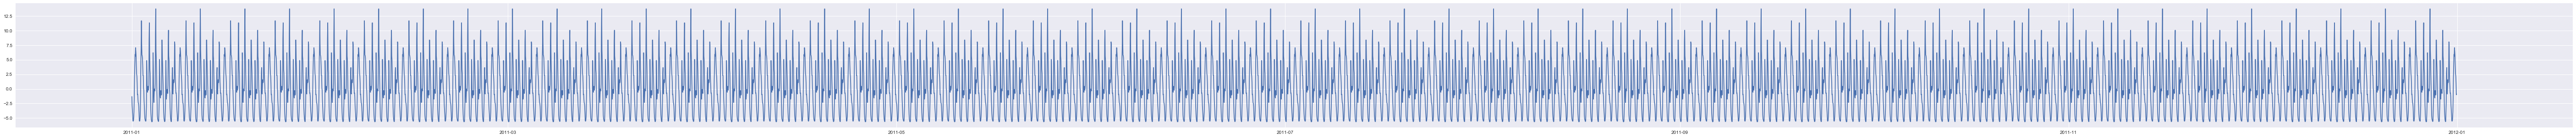

Trend


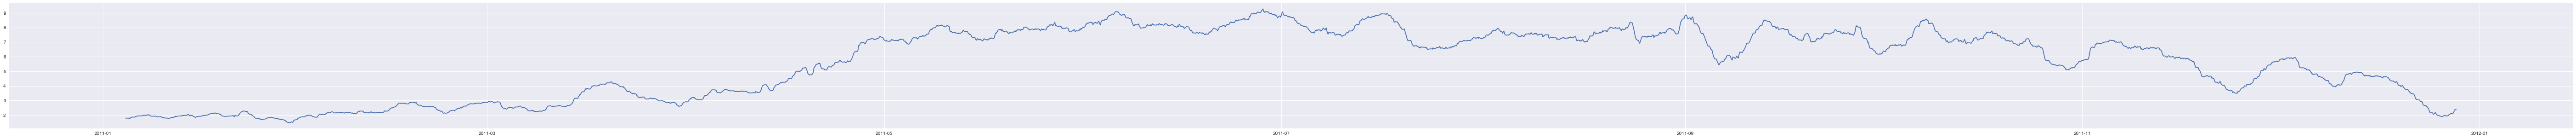

Residual


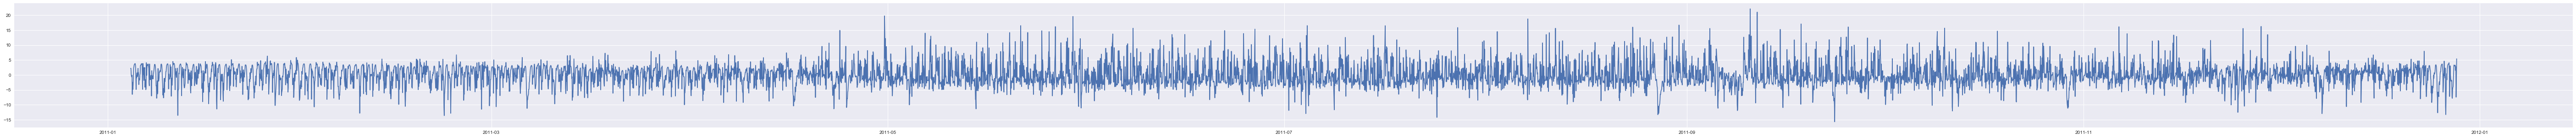

31103
Seasonality


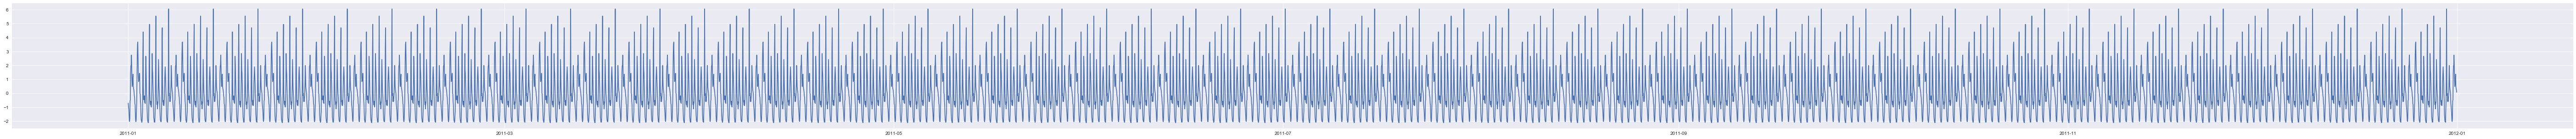

Trend


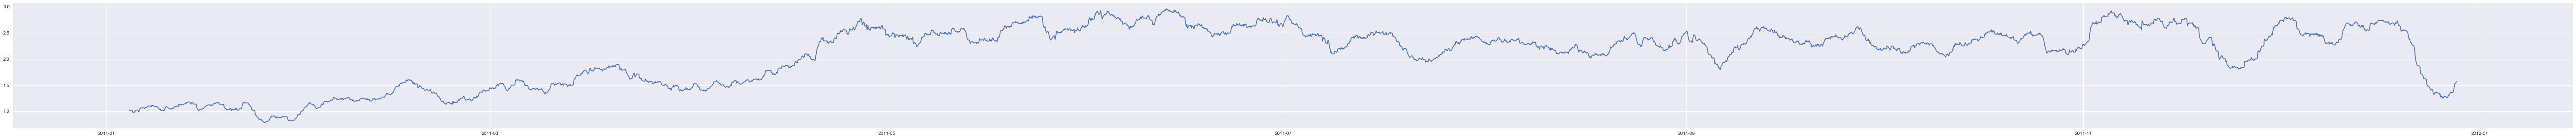

Residual


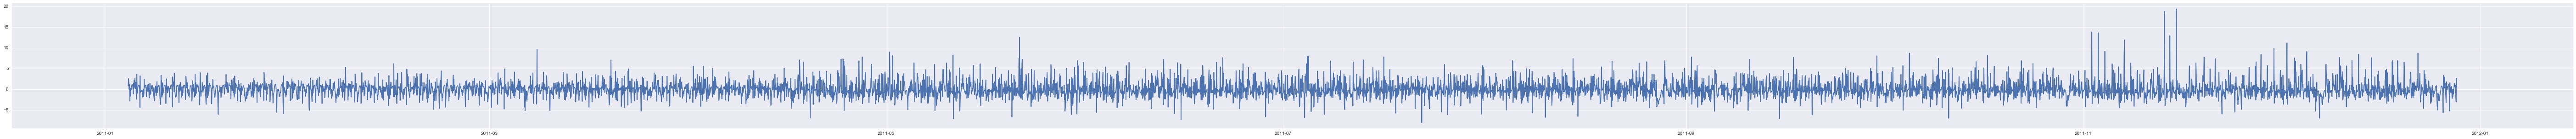

In [67]:
list_sites_start = []
list_sites_end = []
zscore = lambda x: norm.cdf((x - x.mean()) / x.std())
pd.options.display.max_rows = 999

# first, we will transform the hourly counts into a residual, factoring away the weekly seasonality and trend (ie. more trips
# during summer months relative to other seasons)
#
# from there, we will get a 'probability' score, which should trigger an anomaly where appropriate (ie. > 0.99 or < 0.01)
for site in [31200,31103]:
    # each 'season' is 7 days, with 24 hours in each day
    decompfreq = 24*7
        
    result_start = seasonal_decompose(df_hourly_start.fillna(0)[site].values,model='additive',freq=decompfreq)
    result_end = seasonal_decompose(df_hourly_end.fillna(0)[site].values,model='additive',freq=decompfreq)

    df_decomp_start = createDecompDF(result_start,df_hourly_start.index)
    df_decomp_start['dayofweek'] = df_decomp_start.index.dayofweek
    df_decomp_start['hourofday'] = df_decomp_start.index.hour

    df_decomp_end = createDecompDF(result_end,df_hourly_end.index)
    df_decomp_end['dayofweek'] = df_decomp_end.index.dayofweek
    df_decomp_end['hourofday'] = df_decomp_end.index.hour    
    
    group_decomp_start = df_decomp_start.groupby(['dayofweek','hourofday'])
    group_decomp_end = df_decomp_end.groupby(['dayofweek','hourofday'])
    
    xform_start = group_decomp_start['count_resid'].transform(zscore)
    xform_end = group_decomp_end['count_resid'].transform(zscore)
    
    df_xform_start = pd.DataFrame(index=xform_start.index)
    df_xform_start['site'] = site
    df_xform_start['count'] = df_hourly_start[site]
    df_xform_start['count_seasonal'] = df_decomp_start['count_seasonal']
    df_xform_start['count_trend'] = df_decomp_start['count_trend']
    df_xform_start['count_resid'] = df_decomp_start['count_resid']
    df_xform_start['dayofweek'] = df_xform_start.index.dayofweek
    df_xform_start['hourofday'] = df_xform_start.index.hour
    df_xform_start['prob'] = xform_start.values
    
    df_xform_end = pd.DataFrame(index=xform_end.index)
    df_xform_end['site'] = site
    df_xform_end['count'] = df_hourly_end[site]
    df_xform_end['count_seasonal'] = df_decomp_end['count_seasonal']
    df_xform_end['count_trend'] = df_decomp_end['count_trend']
    df_xform_end['count_resid'] = df_decomp_end['count_resid']
    df_xform_end['dayofweek'] = df_xform_end.index.dayofweek
    df_xform_end['hourofday'] = df_xform_end.index.hour
    df_xform_end['prob'] = xform_end.values
    
    print(site)
    print('Seasonality')
    plt.figure(figsize=(100,5))
    plt.plot(df_xform_start['count_seasonal'])
    plt.show()
    print('Trend')
    plt.figure(figsize=(100,5))
    plt.plot(df_xform_start['count_trend'])
    plt.show()
    print('Residual')
    plt.figure(figsize=(100,5))
    plt.plot(df_xform_start['count_resid'])
    plt.show()
    
    list_sites_start.append(df_xform_start)
    list_sites_end.append(df_xform_end) 

df_hourly_start_score = pd.concat(list_sites_start)
df_hourly_end_score = pd.concat(list_sites_end)

In [61]:
df_hourly_start_score.sort_values('prob',ascending=False)

,site,count,count_seasonal,count_trend,count_resid,dayofweek,hourofday,prob
2011-05-02 00:00:00,31103,9.0,-1.574100,2.485119,8.088981,0,0,1.000000
2011-12-22 11:00:00,31103,10.0,-0.591666,1.869048,8.722618,3,11,0.999999
2011-08-23 15:00:00,31200,24.0,-0.338925,8.333333,16.005591,1,15,0.999998
2011-10-04 00:00:00,31103,4.0,-1.713514,2.107143,3.606371,1,0,0.999995
2011-05-30 01:00:00,31103,4.0,-1.927333,2.538690,3.388643,0,1,0.999994
2011-11-13 12:00:00,31103,25.0,3.681911,2.595238,18.722851,6,12,0.999992
2011-10-10 15:00:00,31200,23.0,0.106228,7.226190,15.667582,0,15,0.999992
2011-09-11 19:00:00,31200,31.0,2.324774,7.630952,21.044274,6,19,0.999988
2011-07-04 22:00:00,31103,10.0,-0.340323,2.440476,7.899847,0,22,0.999987
2011-05-31 15:00:00,31103,6.0,-0.992056,2.625000,4.367056,1,15,0.999984


In [64]:
print('# of start records:', len(df_hourly_start_score))
print('# of start records over 0.99:', len(df_hourly_start_score[df_hourly_start_score['prob']>0.99]))
print('# of start records under 0.01:', len(df_hourly_start_score[df_hourly_start_score['prob']<0.01]))

# of start records: 17518
# of start records over 0.99: 294
# of start records under 0.01: 17


In [65]:
print('# of end records:', len(df_hourly_end_score))
print('# of end records over 0.99:', len(df_hourly_end_score[df_hourly_end_score['prob']>0.99]))
print('# of end records under 0.01:', len(df_hourly_end_score[df_hourly_end_score['prob']<0.01]))

# of end records: 17518
# of end records over 0.99: 311
# of end records under 0.01: 22
